# P4 - Project Advanced Lane Finding

This is the jupyter notebook.

[here](./writeup.md) is the writeup file.

The goals / steps of this project are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
# bug with anaconda
import matplotlib
matplotlib.use('qt5agg')

# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

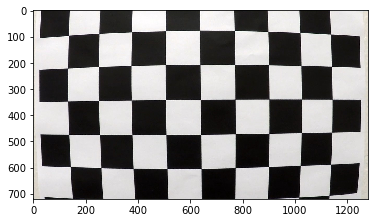

In [3]:
# examine the chessboard picture
img_example = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img_example)

In [4]:
# Count number of intersections
nx = 9
ny = 6

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### Add up the 3D intersections in all pictures into a 2D array and calculate the distortion

In [5]:

%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
#print('images: ', images)
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# calculate the camera calibration
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

### plot an undistorted chessboard image

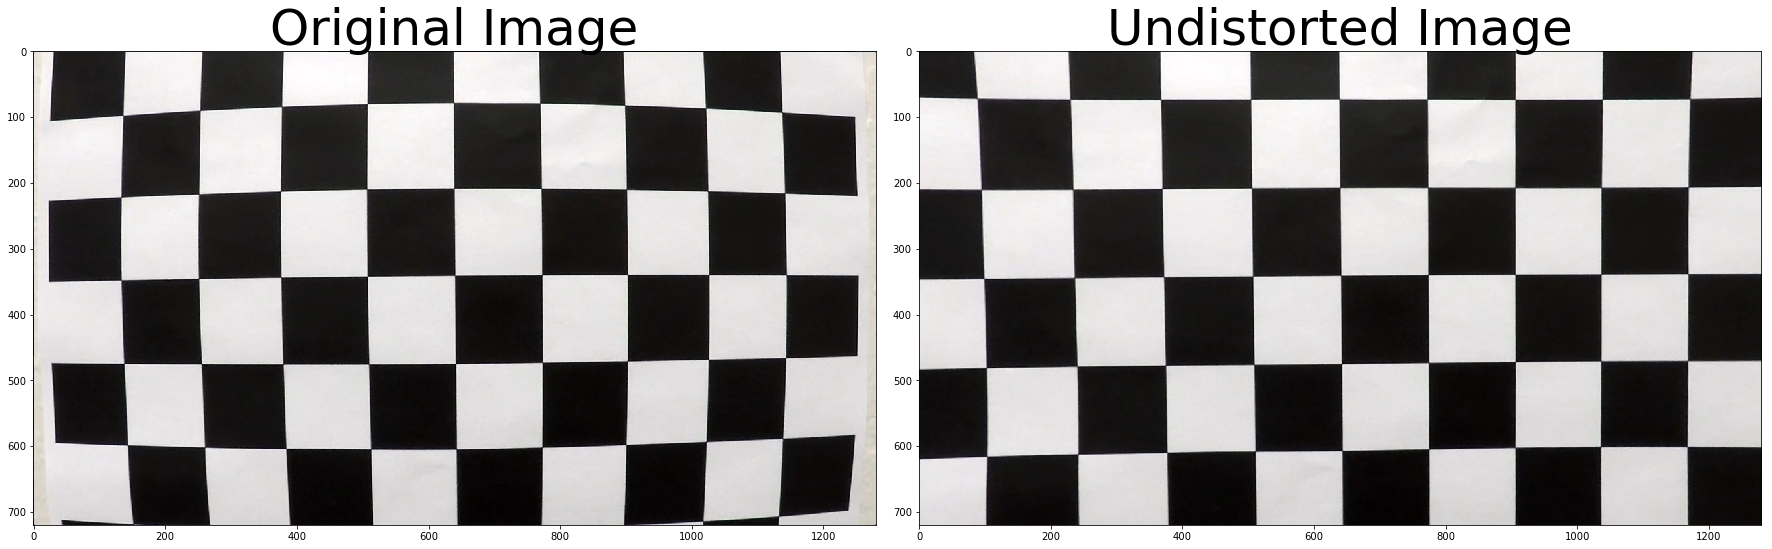

In [12]:

%matplotlib inline

undist_example = cv2.undistort(img_example, mtx, dist, None, mtx) 

def plottwoimages(image1,text1,image2,text2,fname):
    

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(text1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(text2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig(fname)


plottwoimages(img_example,'Original Image',undist_example,'Undistorted Image',"./output_images/an_undistorted_chessboard_image.png")


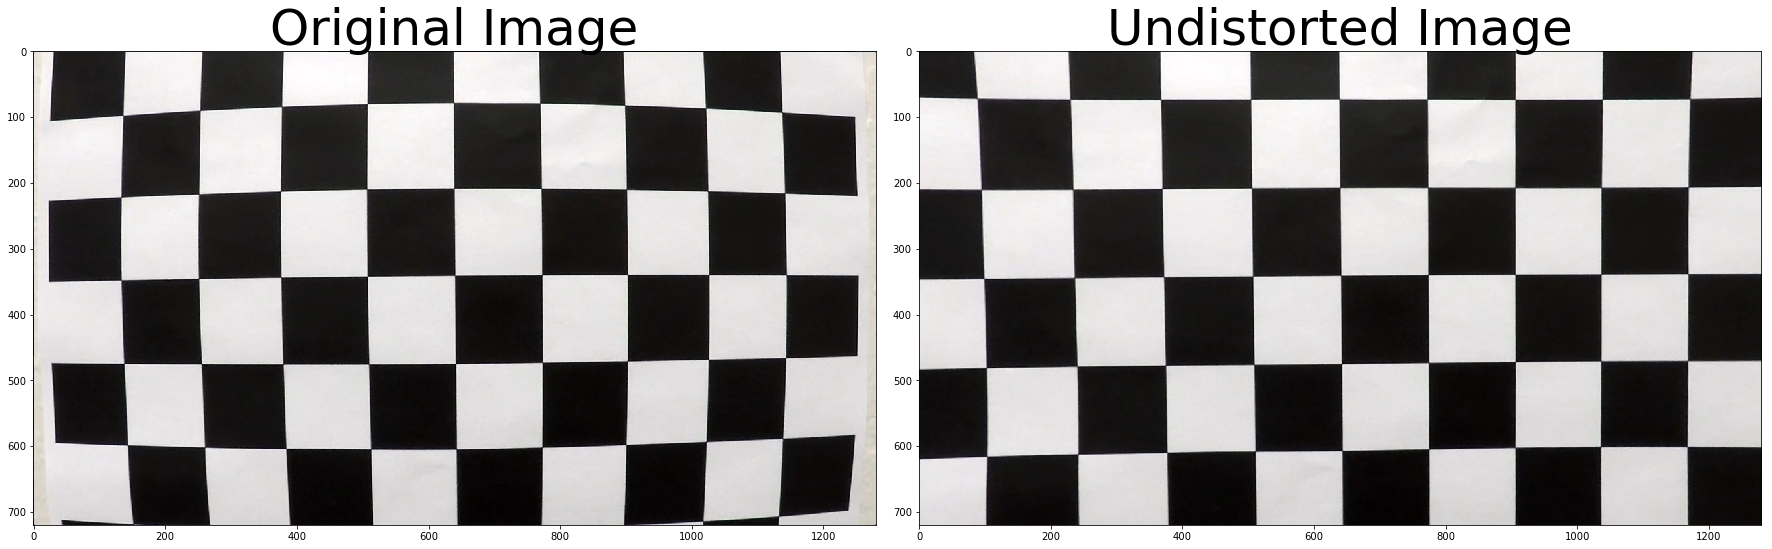

In [68]:
%matplotlib inline

undist_example = cv2.undistort(img_example, mtx, dist, None, mtx) 

def plottwoimages(image1,text1,image2,text2,fname):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if len(image1.shape) == 2:
        ax1.imshow(image1,cmap='gray')
    else:
        ax1.imshow(image1)
    ax1.set_title(text1, fontsize=50)
    if len(image2.shape) == 2:
        ax2.imshow(image2,cmap='gray')
    else:
        ax2.imshow(image2)
    ax2.set_title(text2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig(fname)


plottwoimages(img_example,'Original Image',undist_example,'Undistorted Image',"./output_images/an_undistorted_chessboard_image.png")



## 2. Apply a distortion correction to raw images. 

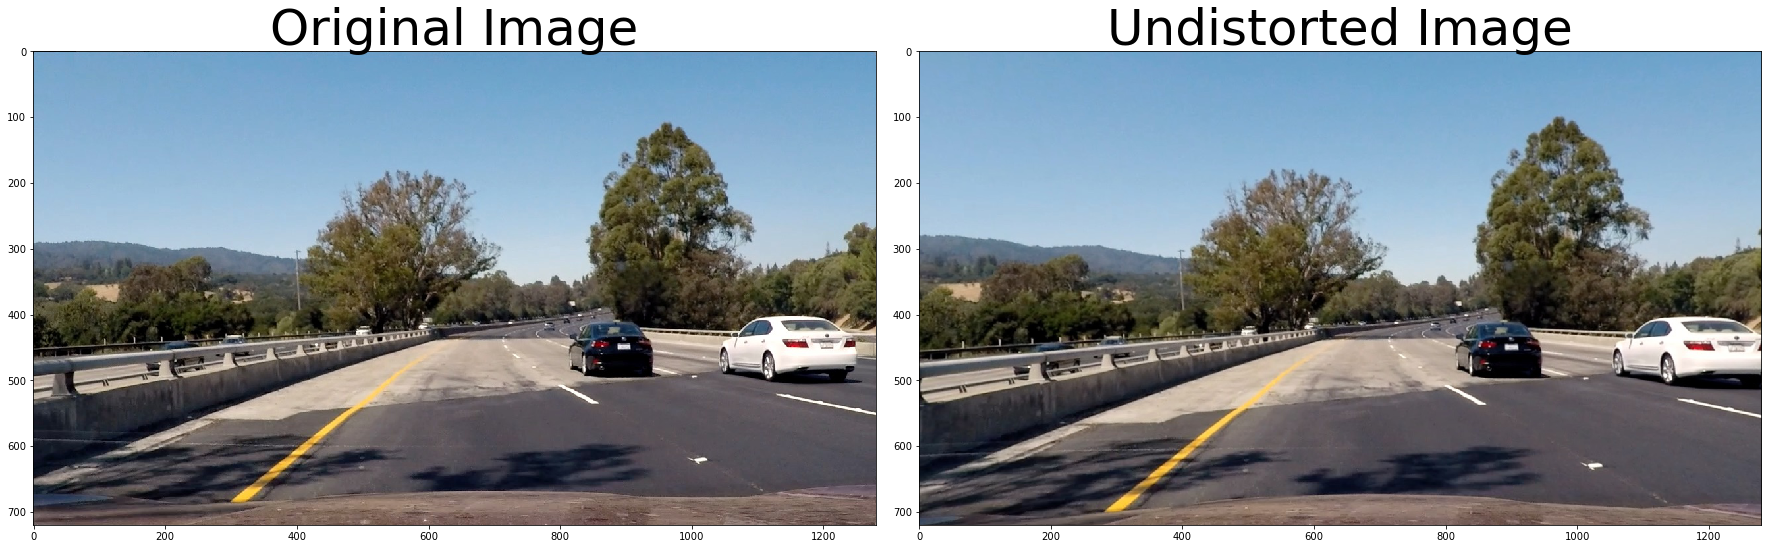

In [69]:
# plot an undistorted traffic image
%matplotlib inline

img_example2 = mpimg.imread('./test_images/test4.jpg')

undist_example2 = cv2.undistort(img_example2, mtx, dist, None, mtx) 

plottwoimages(img_example2,'Original Image',undist_example2,'Undistorted Image',"./output_images/an_undistorted_traffic_image.png")


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

### Define Sobel functions for x,y, magnitude of gradient, direction and colour of the gradient

In [73]:
# using sobel to create a thresholded binary image

# defining functions that applies Sobel x or y, 
def abs_sobel_thresh(img, orient='x', thresh=(0, 255),sobel_kernel=3):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary # Remove this line
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(angle)
    sbinary[(angle >= thresh[0]) & (angle <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary # Remove this line
    return binary_output


def col_threshold(img, HLS_thres=(170, 255), HSV_thres=(200,255)):
    # 1) Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) find the s channel
    s = hls[:,:,2]
    # 3) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(s)
    sbinary[(s > HLS_thres[0]) & (s <= HLS_thres[1])] = 1
    
    # 4) Convert to HLC
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 5) find the s channel
    v = hsv[:,:,2]
    # 6) Create a binary mask where direction thresholds are met
    vbinary = np.zeros_like(v)
    vbinary[(v > HSV_thres[0]) & (v <= HSV_thres[1])] = 1  
    
    # 7) Combine the s and v channel
    binary_output = np.zeros_like(s)
    binary_output[(sbinary == 1) & (vbinary == 1)] = 1
    return binary_output


def apply_gradients(image):
    ksize = 7 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    gradx = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=((0.65, 1.1)))
    col_binary = col_threshold(image, HLS_thres=(170, 255), HSV_thres=(200,255))
    #col_binary = col_threshold2(image)
        
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    binary = np.zeros_like(combined)
    binary[(col_binary > 0) | (combined > 0)] = 1
        
    return binary


def crop_image(image):
    height = image.shape[0]
    width = image.shape[1]
    
    mask = np.zeros_like(image)
    vertices = np.array([[(100, height), (450, 400), (800, 400), (1200, height)]], dtype=np.int32)
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
        # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image



### apply the functions to test images

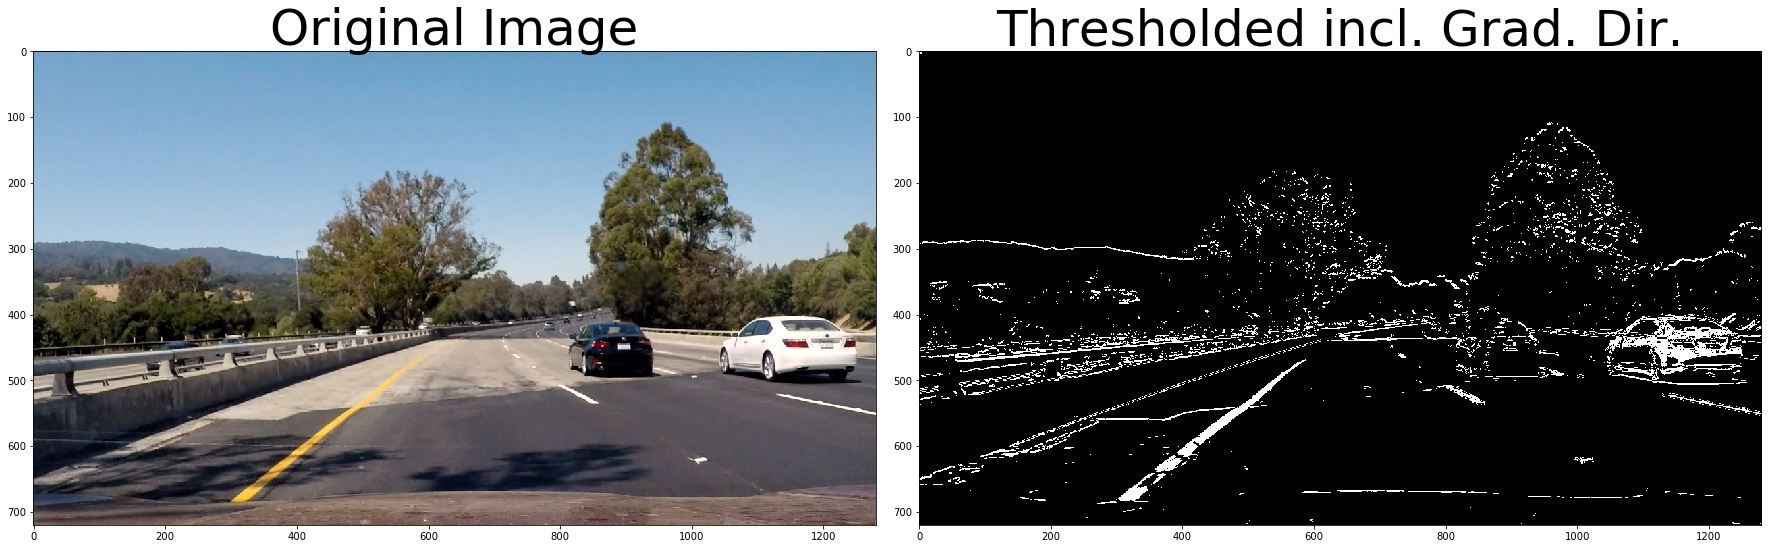

In [74]:
### apply the functions to test images

image = img_example2
# Choose a Sobel kernel size

# Run the function
combined_gradients = apply_gradients(img_example2)

# Plot the result
plottwoimages(img_example2,'Original Image',combined_gradients,"Thresholded incl. Grad. Dir.","./output_images/Thresholded_incl_Grad_Dir.png")



### Crop the mask to the region of interest

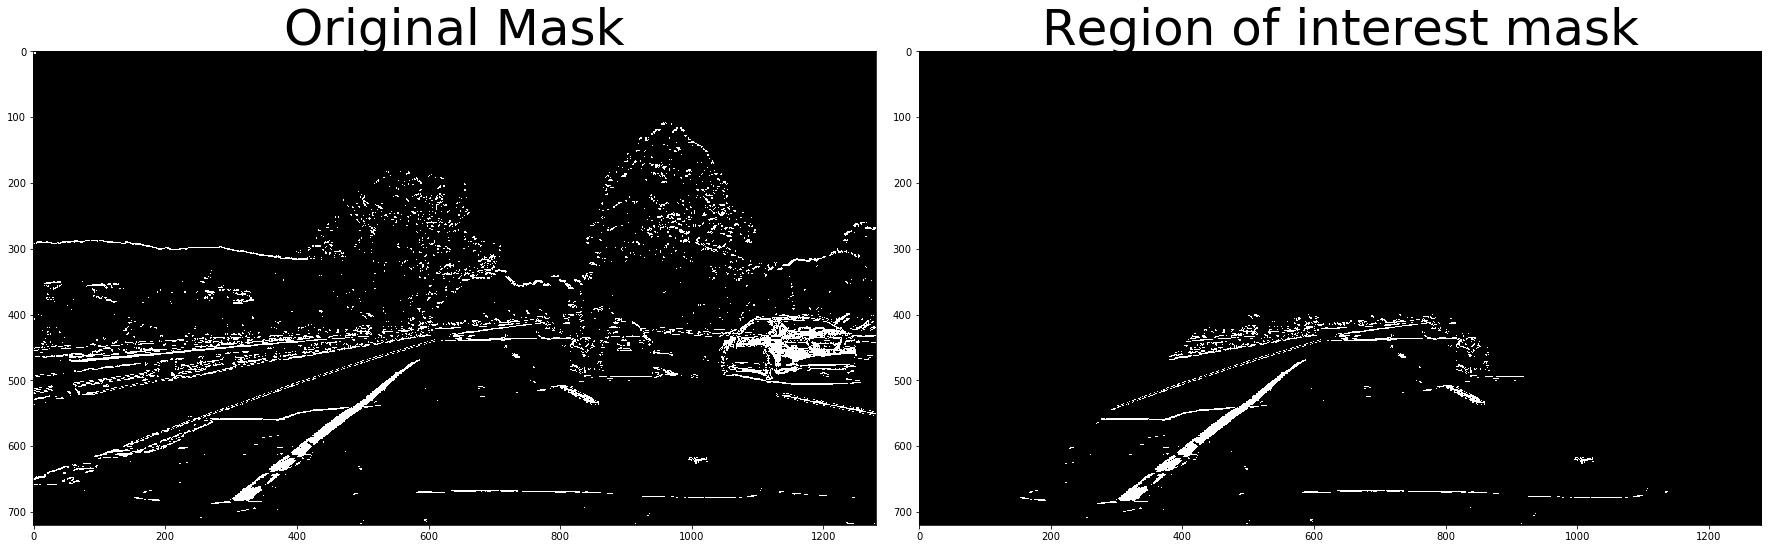

In [78]:
### apply the functions to test images

image = img_example2
# Choose a Sobel kernel size

# Run the function
crop_mask = crop_image(combined_gradients)

# Plot the result
plottwoimages(combined_gradients,'Original Mask',crop_mask,"Region of interest mask","./output_images/region_of_interest_mask.png")



## 4. Apply a perspective transform to rectify binary image ("birds-eye view").